In [109]:
import numpy as np
from scipy.spatial.distance import euclidean
import scipy
import torch

import dtw
import dtwalign
from fastdtw import fastdtw

from sklearn.manifold import TSNE
import pandas as pd

from src.speech_classification.audio_processing import AudioPreprocessorFbank, SpeechCommandsDataCollector
from src.siamese_net_sound_similarity.slstm_train import SiameseSpeechCommandsDataCollector, StochasticSiameseLSTMNet
from src.siamese_net_sound_similarity.train import SiameseLSTMNet


import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()

%matplotlib inline

## Load data

In [110]:
wanted_words = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left',
                'marvin',
                'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two',
                'up', 'wow', 'yes', 'zero']

wanted_words_combined = wanted_words

model_settings = {
    'dct_coefficient_count': 26,
    'label_count': len(wanted_words_combined) + 2,
    'hidden_reccurent_cells_count': 128,
    'winlen': 0.04,
    'winstep': 0.02
}

In [111]:
preproc = AudioPreprocessorFbank(nfilt=model_settings['dct_coefficient_count'], winlen=model_settings['winlen'],
                                     winstep=model_settings['winstep'])

data_iter = SiameseSpeechCommandsDataCollector(preproc,
                                        data_dir=r'C:\Study\Speech_command_classification\speech_dataset',
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

index_to_word = {v:k for k,v in data_iter.word_to_index.items()}

In [112]:
n_mini_batch_size = 1
data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])

Text(0.5,1,'negative DTW = 0.0011')

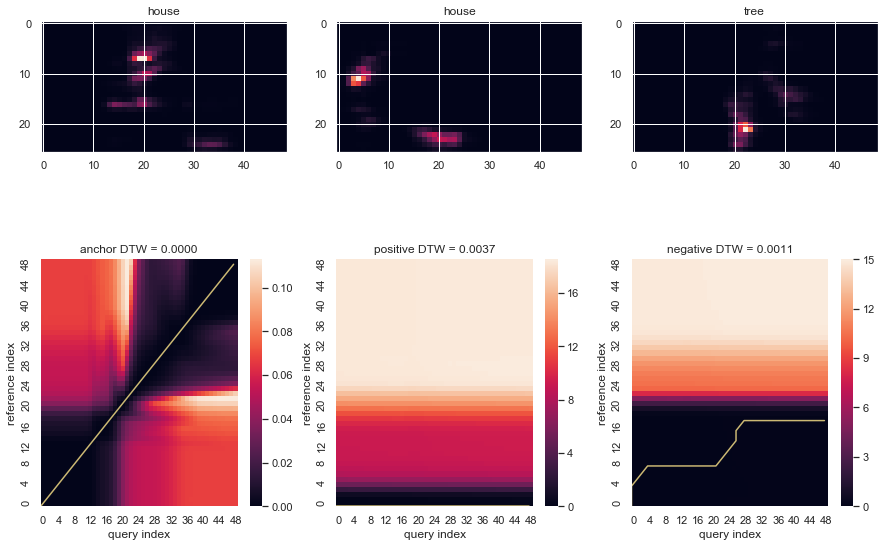

In [113]:

i = np.random.randint(data['y'].shape[0])
sample_idx = i

fig, axes = plt.subplots(2, 3, figsize=(15,10))

# plt.figure()
im = axes[0][0].imshow(data['x'][i].T)
# fig.colorbar(im)
label = index_to_word[data['y'][0]]
axes[0][0].title.set_text(f'{label}')

axes[0][1].imshow(duplicates['x'][i].T)
# plt.colorbar()
label = index_to_word[data['y'][0]]
axes[0][1].title.set_text(f'{label}')


axes[0][2].imshow(non_duplicates['x'][i].T)
# plt.colorbar()
label = index_to_word[non_duplicates['y'][0]]
axes[0][2].title.set_text(f'{label}')

######################################## DTW

x = data['x'][i]

# self dtw (extpected to be 0)

y = data['x'][i]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][0])
axes[1][0].set_title(f"anchor DTW = {res.normalized_distance:.4f}")


# positive dtw

y = duplicates['x'][sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][1])
axes[1][1].set_title(f"positive DTW = {res.normalized_distance:.4f}")


# negative dtw

y = non_duplicates['x'][sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][2])
axes[1][2].set_title(f"negative DTW = {res.normalized_distance:.4f}")

# Gather Data for analysis

In [172]:
n_mini_batch_size = 1000

# gather data


data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])


## DTW distribution on raw data

In [173]:

# initialize dist_lists

duplicates_dtw = []
non_duplicates_dtw = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = data['x'][i].squeeze()
    
    y_duplicate = duplicates['x'][i].squeeze()
    duplicates_dtw.append(dtwalign.dtw(x, y_duplicate, dist=euclidean, open_end=False, dist_only=True).normalized_distance)

    y_non_duplicate = non_duplicates['x'][i].squeeze()
    non_duplicates_dtw.append(dtwalign.dtw(x, y_non_duplicate, dist=euclidean, open_end=False, dist_only=True).normalized_distance)    

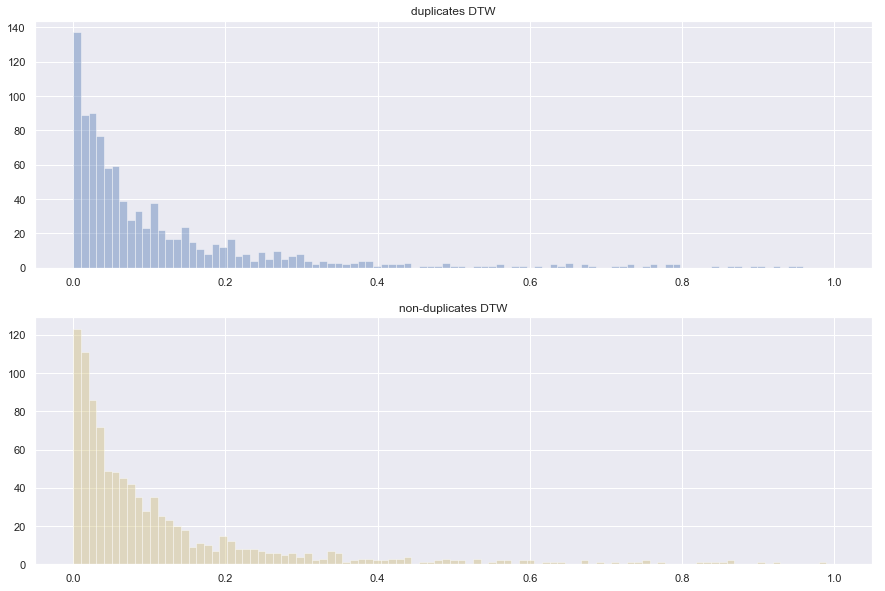

In [174]:
bins = np.linspace(0, 1., 100)
fig, axes = plt.subplots(2, 1, figsize=(15,10))

duplicates_dtw_filtered = np.array(duplicates_dtw)[np.where(np.array(duplicates_dtw) < 1.)]
non_duplicates_dtw_filtered = np.array(non_duplicates_dtw)[np.where(np.array(non_duplicates_dtw) < 1.)]


sns.distplot(duplicates_dtw_filtered, bins=bins, ax=axes[0], kde=False)
axes[0].title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw_filtered, bins=bins, color='y', ax=axes[1], kde=False)
axes[1].title.set_text('non-duplicates DTW')
plt.show()

### KL Divergence between two DTW distributions:

In [175]:
hist_dup, _ = np.histogram(duplicates_dtw, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")


DKL is: 0.1177


### As it can be seen, DTW calculated on MFCCs signals failed to capture different and similar samples showing no significant difference between duplicates and non-duplicates pairs. Kullback-Leibler divergence just proves this fact that P (distribution of distances between duplicate samples) and Q (non-duplicate ones) have no significant difference.

# Improving DTW using latent variables from LSTM classifier as a signal

In [267]:
# load nn

nn_fname = r'C:/Study/SpeechAcquisitionModel/reports/seamise_net_09_23_2019_03_35_PM/net_0.44140625.net'

nn = torch.load(nn_fname)

In [268]:
nn_input = torch.from_numpy(data['x']).cuda().float()

In [269]:
z, *_ = nn.single_forward(nn_input)
z = z.detach().cpu().numpy()

duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
duplicates_z = duplicates_z.detach().cpu().numpy()

non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

## Embedding and DTW

In [270]:


# random latent variables
# z, _, _, _ = nn.single_forward(nn_input)
# z = z.detach().cpu().numpy()

# duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
# duplicates_z = duplicates_z.detach().cpu().numpy()

# non_duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
# non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

Text(0.5,1,'negative DTW = 104.9654')

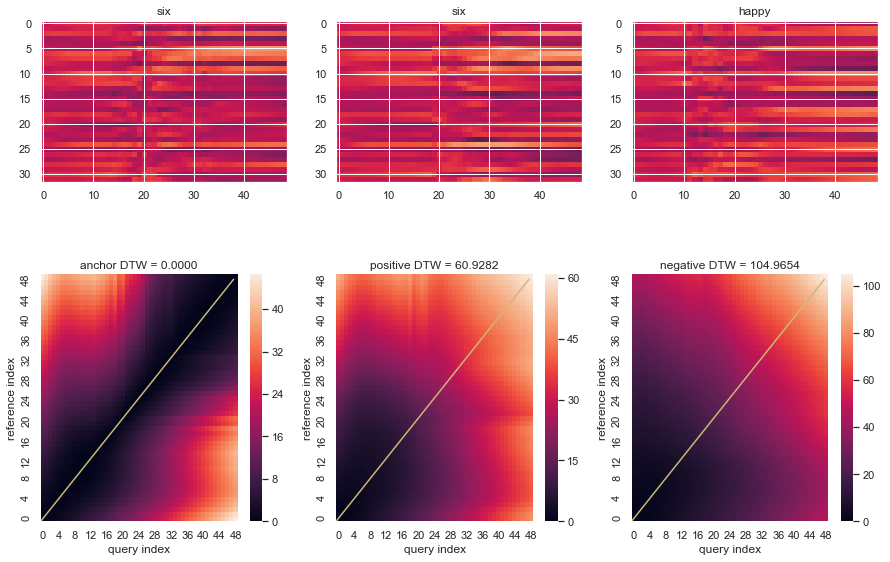

In [273]:

i = np.random.randint(data['y'].shape[0])
sample_idx = i

fig, axes = plt.subplots(2, 3, figsize=(15,10))

# plt.figure()
im = axes[0][0].imshow(z[i].T, vmin=-1, vmax=1)
# fig.colorbar(im)
label = index_to_word[data['y'][i]]
axes[0][0].title.set_text(f'{label}')

axes[0][1].imshow(duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[data['y'][i]]
axes[0][1].title.set_text(f'{label}')


axes[0][2].imshow(non_duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[non_duplicates['y'][i]]
axes[0][2].title.set_text(f'{label}')

######################################## DTW

x = z[sample_idx]

# self dtw (extpected to be 0)

y = z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][0])
axes[1][0].set_title(f"anchor DTW = {res.distance:.4f}")


# positive dtw

y = duplicates_z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=False)
res.plot_path(ax=axes[1][1])
axes[1][1].set_title(f"positive DTW = {res.distance:.4f}")


# negative dtw

y = non_duplicates_z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=False)
res.plot_path(ax=axes[1][2])
axes[1][2].set_title(f"negative DTW = {res.distance:.4f}")

# 1.1 DTW distribution in latent space z (open_end=True)

In [274]:

# initialize dist_lists

duplicates_dtw_z = []
non_duplicates_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i].squeeze()
    
    y_duplicate = duplicates_z[i].squeeze()
    duplicates_dtw_z.append(dtwalign.dtw(x, y_duplicate, dist=euclidean, open_end=True, dist_only=True).distance)

    y_non_duplicate = non_duplicates_z[i].squeeze()
    non_duplicates_dtw_z.append(dtwalign.dtw(x, y_non_duplicate, dist=euclidean, open_end=True, dist_only=True).distance)    

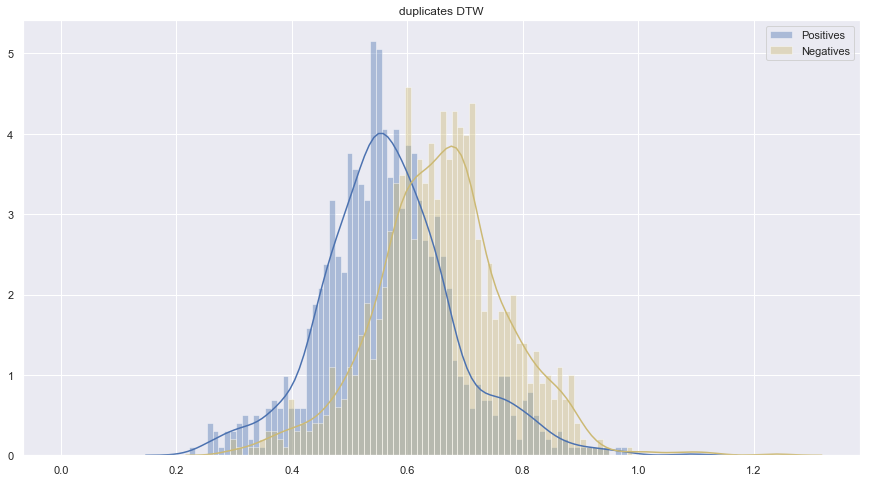

DKL is: 0.5164


In [235]:
bins = np.linspace(0, 1., 100)
fig, axes = plt.subplots(1, 1, figsize=(15,8))

sns.distplot(duplicates_dtw_z, ax=axes, bins=bins, label="Positives")
axes.title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Negatives')
axes.legend()
# axes[1].title.set_text('non-duplicates DTW')
plt.show()

hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")

# 1.2 DTW distribution in latent space z (open_end=False)

In [236]:

# initialize dist_lists

duplicates_dtw_z = []
non_duplicates_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i].squeeze()
    
    y_duplicate = duplicates_z[i].squeeze()
    duplicates_dtw_z.append(dtwalign.dtw(x, y_duplicate, dist=euclidean, open_end=False, dist_only=True).normalized_distance)

    y_non_duplicate = non_duplicates_z[i].squeeze()
    non_duplicates_dtw_z.append(dtwalign.dtw(x, y_non_duplicate, dist=euclidean, open_end=False, dist_only=True).normalized_distance)    

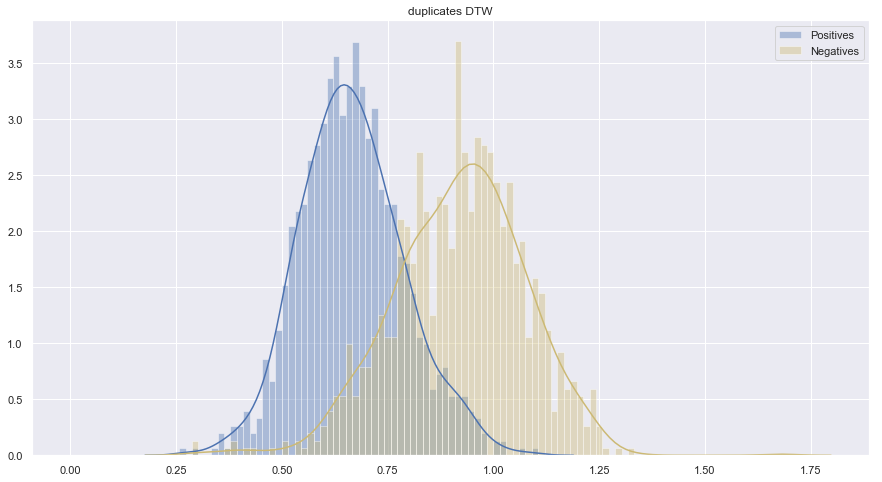

DKL is: 1.7515


In [237]:
bins = np.linspace(0, 1.5, 100)
fig, axes = plt.subplots(1, 1, figsize=(15,8))

sns.distplot(duplicates_dtw_z, ax=axes, bins=bins, label="Positives")
axes.title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Negatives')
axes.legend()
# axes[1].title.set_text('non-duplicates DTW')
plt.show()

hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")

# 2. DTW (prefix case n << m) n = 40

In [238]:
PREFIX_LEN = 40

In [239]:
nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).cuda().float()

In [240]:
z, *_ = nn.single_forward(nn_input)
z = z.detach().cpu().numpy()

duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
duplicates_z = duplicates_z.detach().cpu().numpy()

non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

In [241]:
# random latent variables
# z, _, _, _ = nn.single_forward(nn_input)
# z = z.detach().cpu().numpy()

# duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
# duplicates_z = duplicates_z.detach().cpu().numpy()

# non_duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
# non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

Text(0.5,1,'negative DTW = 0.4641')

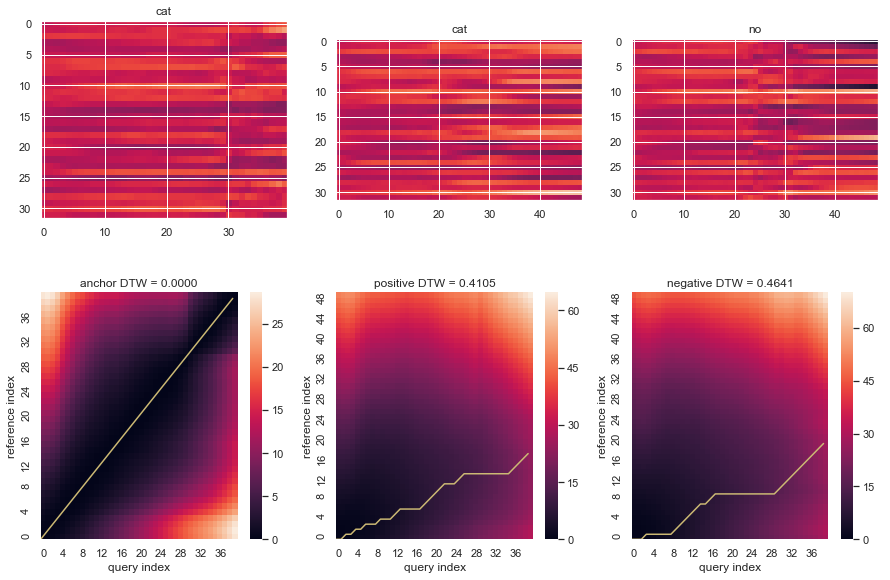

In [242]:

i = np.random.randint(data['y'].shape[0])
sample_idx = i

fig, axes = plt.subplots(2, 3, figsize=(15,10))

# plt.figure()
im = axes[0][0].imshow(z[i].T, vmin=-1, vmax=1)
# fig.colorbar(im)
label = index_to_word[data['y'][i]]
axes[0][0].title.set_text(f'{label}')

axes[0][1].imshow(duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[data['y'][i]]
axes[0][1].title.set_text(f'{label}')


axes[0][2].imshow(non_duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[non_duplicates['y'][i]]
axes[0][2].title.set_text(f'{label}')

######################################## DTW

x = z[sample_idx]

# self dtw (extpected to be 0)

y = z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][0])
axes[1][0].set_title(f"anchor DTW = {res.normalized_distance:.4f}")


# positive dtw

y = duplicates_z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][1])
axes[1][1].set_title(f"positive DTW = {res.normalized_distance:.4f}")


# negative dtw

y = non_duplicates_z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][2])
axes[1][2].set_title(f"negative DTW = {res.normalized_distance:.4f}")

# 2.1 DTW distribution in latent space z (open_end=True)

In [243]:

# initialize dist_lists

duplicates_dtw_z = []
non_duplicates_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i].squeeze()
    
    y_duplicate = duplicates_z[i].squeeze()
    duplicates_dtw_z.append(dtwalign.dtw(x, y_duplicate, dist=euclidean, open_end=True, dist_only=True).normalized_distance)

    y_non_duplicate = non_duplicates_z[i].squeeze()
    non_duplicates_dtw_z.append(dtwalign.dtw(x, y_non_duplicate, dist=euclidean, open_end=True, dist_only=True).normalized_distance)    

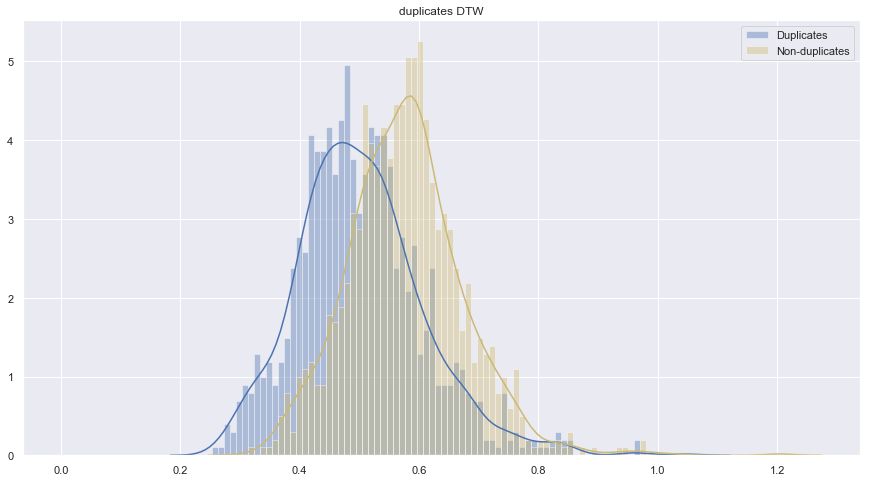

DKL is: 0.5891


In [244]:
bins = np.linspace(0, 1., 100)
fig, axes = plt.subplots(1, 1, figsize=(15,8))

sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Duplicates")
axes.title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Non-duplicates')
axes.legend()
# axes[1].title.set_text('non-duplicates DTW')
plt.show()

hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")

# 2.2 DTW distribution in latent space z (open_end=False)

In [245]:

# initialize dist_lists

duplicates_dtw_z = []
non_duplicates_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i].squeeze()
    
    y_duplicate = duplicates_z[i].squeeze()
    duplicates_dtw_z.append(dtwalign.dtw(x, y_duplicate, dist=euclidean, open_end=False, dist_only=True).normalized_distance)

    y_non_duplicate = non_duplicates_z[i].squeeze()
    non_duplicates_dtw_z.append(dtwalign.dtw(x, y_non_duplicate, dist=euclidean, open_end=False, dist_only=True).normalized_distance)    

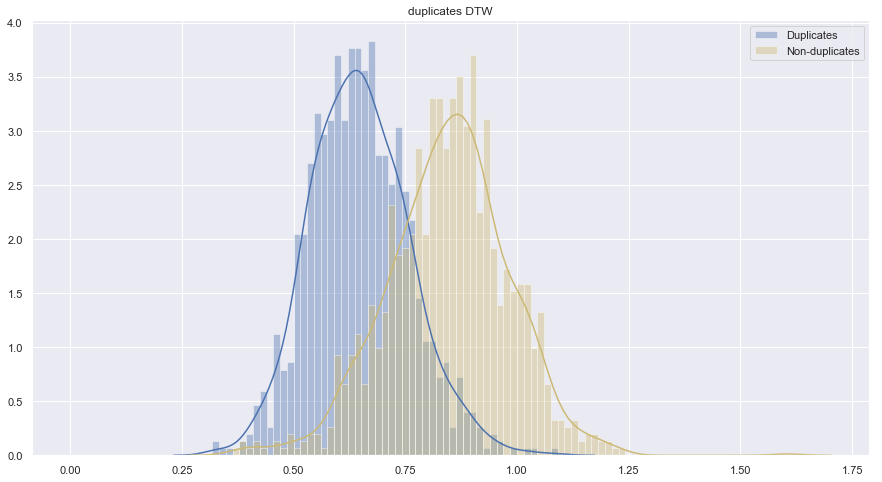

DKL is: 1.2739


In [246]:
bins = np.linspace(0, 1.5, 100)
fig, axes = plt.subplots(1, 1, figsize=(15,8))

sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Duplicates")
axes.title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Non-duplicates')
axes.legend()
# axes[1].title.set_text('non-duplicates DTW')
plt.show()

hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")

# 3. DTW (prefix case n << m) n = 30

In [247]:
PREFIX_LEN = 30

In [248]:
nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).cuda().float()

In [249]:
z, *_ = nn.single_forward(nn_input)
z = z.detach().cpu().numpy()

duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
duplicates_z = duplicates_z.detach().cpu().numpy()

non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

In [250]:
# random latent variables
# z, _, _, _ = nn.single_forward(nn_input)
# z = z.detach().cpu().numpy()

# duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
# duplicates_z = duplicates_z.detach().cpu().numpy()

# non_duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
# non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

Text(0.5,1,'negative DTW = 0.5170')

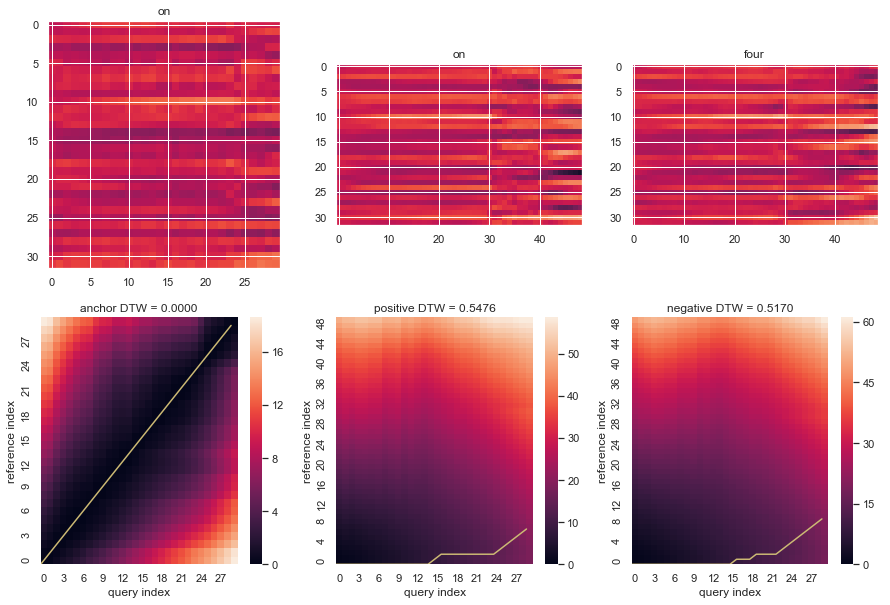

In [251]:

i = np.random.randint(data['y'].shape[0])
sample_idx = i

fig, axes = plt.subplots(2, 3, figsize=(15,10))

# plt.figure()
im = axes[0][0].imshow(z[i].T, vmin=-1, vmax=1)
# fig.colorbar(im)
label = index_to_word[data['y'][i]]
axes[0][0].title.set_text(f'{label}')

axes[0][1].imshow(duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[data['y'][i]]
axes[0][1].title.set_text(f'{label}')


axes[0][2].imshow(non_duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[non_duplicates['y'][i]]
axes[0][2].title.set_text(f'{label}')

######################################## DTW

x = z[sample_idx]

# self dtw (extpected to be 0)

y = z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][0])
axes[1][0].set_title(f"anchor DTW = {res.normalized_distance:.4f}")


# positive dtw

y = duplicates_z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][1])
axes[1][1].set_title(f"positive DTW = {res.normalized_distance:.4f}")


# negative dtw

y = non_duplicates_z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][2])
axes[1][2].set_title(f"negative DTW = {res.normalized_distance:.4f}")

# 3.1 DTW distribution in latent space z (open_end=True)

In [252]:

# initialize dist_lists

duplicates_dtw_z = []
non_duplicates_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i].squeeze()
    
    y_duplicate = duplicates_z[i].squeeze()
    duplicates_dtw_z.append(dtwalign.dtw(x, y_duplicate, dist=euclidean, open_end=True, dist_only=True).normalized_distance)

    y_non_duplicate = non_duplicates_z[i].squeeze()
    non_duplicates_dtw_z.append(dtwalign.dtw(x, y_non_duplicate, dist=euclidean, open_end=True, dist_only=True).normalized_distance)    

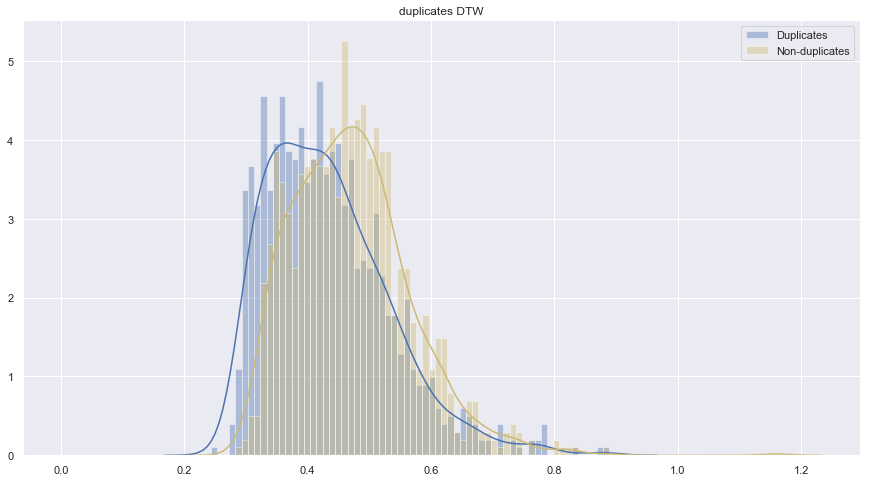

DKL is: 0.2957


In [253]:
bins = np.linspace(0, 1., 100)
fig, axes = plt.subplots(1, 1, figsize=(15,8))

sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Duplicates")
axes.title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Non-duplicates')
axes.legend()
# axes[1].title.set_text('non-duplicates DTW')
plt.show()

hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")

# 3.2 DTW distribution in latent space z (open_end=False)

In [254]:

# initialize dist_lists

duplicates_dtw_z = []
non_duplicates_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i].squeeze()
    
    y_duplicate = duplicates_z[i].squeeze()
    duplicates_dtw_z.append(dtwalign.dtw(x, y_duplicate, dist=euclidean, open_end=False, dist_only=True).normalized_distance)

    y_non_duplicate = non_duplicates_z[i].squeeze()
    non_duplicates_dtw_z.append(dtwalign.dtw(x, y_non_duplicate, dist=euclidean, open_end=False, dist_only=True).normalized_distance)    

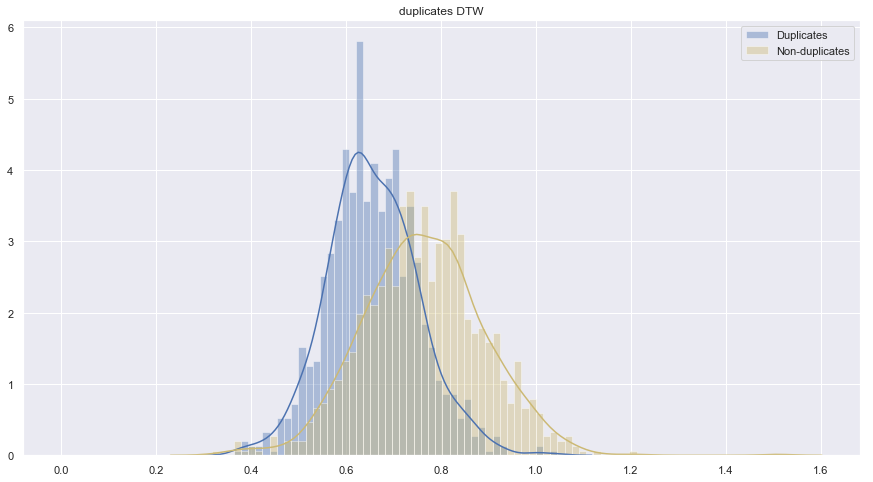

DKL is: 0.5455


In [255]:
bins = np.linspace(0, 1.5, 100)
fig, axes = plt.subplots(1, 1, figsize=(15,8))

sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Duplicates")
axes.title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Non-duplicates')
axes.legend()
# axes[1].title.set_text('non-duplicates DTW')
plt.show()

hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")

# 4. DTW (prefix case n << m) n = 20

In [256]:
PREFIX_LEN = 20

In [257]:
nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).cuda().float()

In [258]:
z, *_ = nn.single_forward(nn_input)
z = z.detach().cpu().numpy()

duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
duplicates_z = duplicates_z.detach().cpu().numpy()

non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

In [259]:
# random latent variables
# z, _, _, _ = nn.single_forward(nn_input)
# z = z.detach().cpu().numpy()

# duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
# duplicates_z = duplicates_z.detach().cpu().numpy()

# non_duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
# non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

Text(0.5,1,'negative DTW = 10.0921')

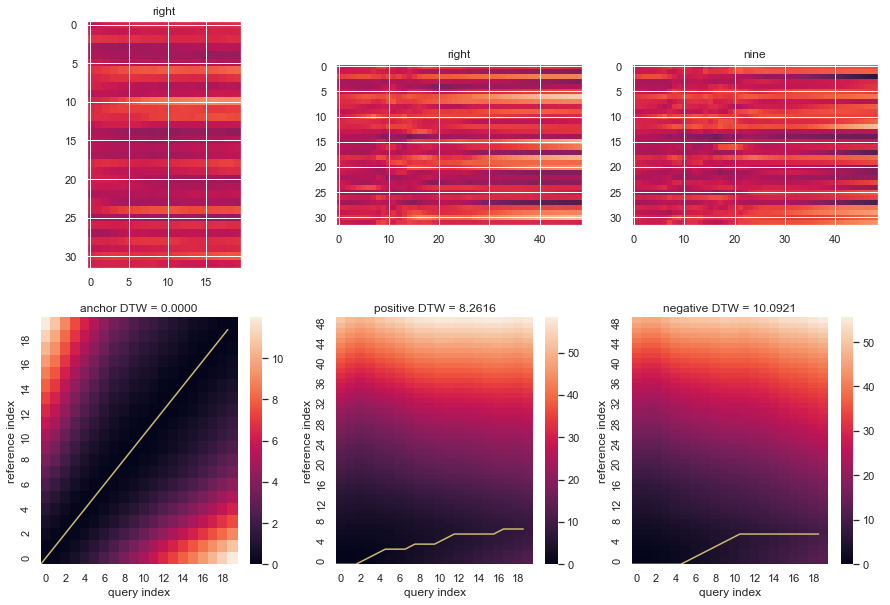

In [266]:

i = np.random.randint(data['y'].shape[0])
sample_idx = i

fig, axes = plt.subplots(2, 3, figsize=(15,10))

# plt.figure()
im = axes[0][0].imshow(z[i].T, vmin=-1, vmax=1)
# fig.colorbar(im)
label = index_to_word[data['y'][i]]
axes[0][0].title.set_text(f'{label}')

axes[0][1].imshow(duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[data['y'][i]]
axes[0][1].title.set_text(f'{label}')


axes[0][2].imshow(non_duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[non_duplicates['y'][i]]
axes[0][2].title.set_text(f'{label}')

######################################## DTW

x = z[sample_idx]

# self dtw (extpected to be 0)

y = z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][0])
axes[1][0].set_title(f"anchor DTW = {res.normalized_distance:.4f}")


# positive dtw

y = duplicates_z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][1])
axes[1][1].set_title(f"positive DTW = {res.distance:.4f}")


# negative dtw

y = non_duplicates_z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][2])
axes[1][2].set_title(f"negative DTW = {res.distance:.4f}")

# 4.1 DTW distribution in latent space z (open_end=True)

In [261]:

# initialize dist_lists

duplicates_dtw_z = []
non_duplicates_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i].squeeze()
    
    y_duplicate = duplicates_z[i].squeeze()
    duplicates_dtw_z.append(dtwalign.dtw(x, y_duplicate, dist=euclidean, open_end=True, dist_only=True).normalized_distance)

    y_non_duplicate = non_duplicates_z[i].squeeze()
    non_duplicates_dtw_z.append(dtwalign.dtw(x, y_non_duplicate, dist=euclidean, open_end=True, dist_only=True).normalized_distance)    

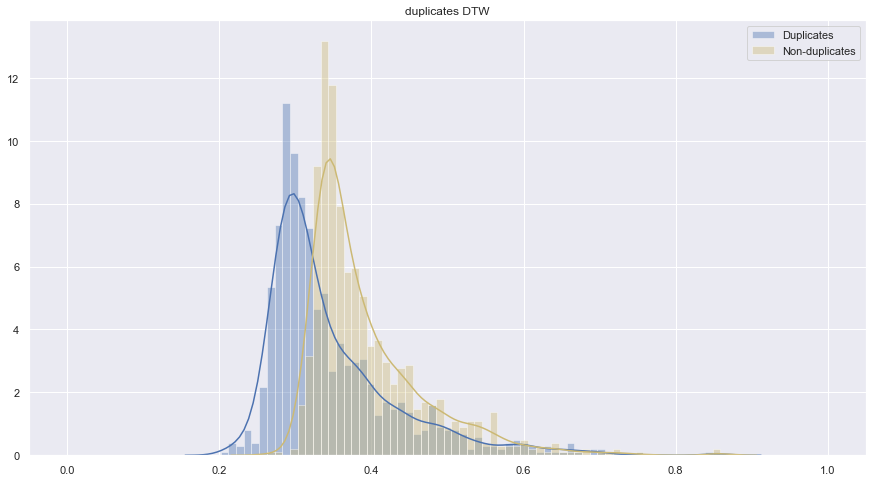

DKL is: 2.1786


In [262]:
bins = np.linspace(0, 1., 100)
fig, axes = plt.subplots(1, 1, figsize=(15,8))

sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Duplicates")
axes.title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Non-duplicates')
axes.legend()
# axes[1].title.set_text('non-duplicates DTW')
plt.show()

hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")

# 4.2 DTW distribution in latent space z (open_end=False)

In [263]:

# initialize dist_lists

duplicates_dtw_z = []
non_duplicates_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i].squeeze()
    
    y_duplicate = duplicates_z[i].squeeze()
    duplicates_dtw_z.append(dtwalign.dtw(x, y_duplicate, dist=euclidean, open_end=False, dist_only=True).normalized_distance)

    y_non_duplicate = non_duplicates_z[i].squeeze()
    non_duplicates_dtw_z.append(dtwalign.dtw(x, y_non_duplicate, dist=euclidean, open_end=False, dist_only=True).normalized_distance)    

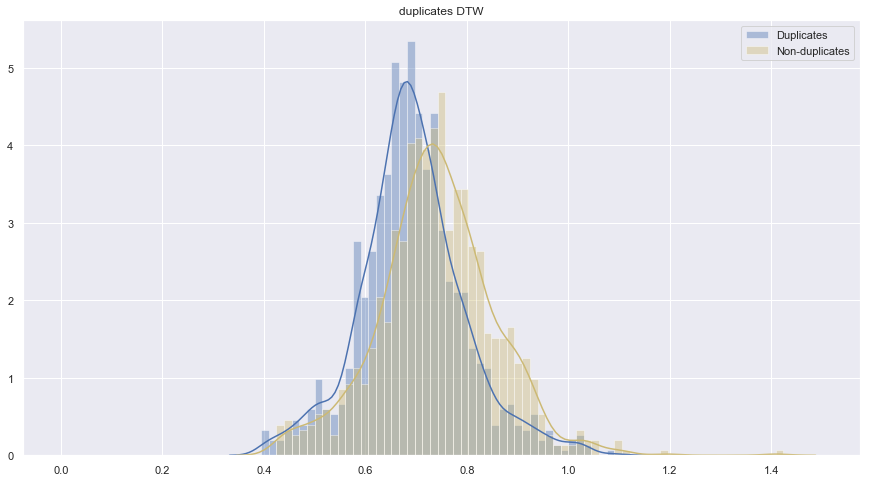

DKL is: 0.1969


In [264]:
bins = np.linspace(0, 1.5, 100)
fig, axes = plt.subplots(1, 1, figsize=(15,8))

sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Duplicates")
axes.title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Non-duplicates')
axes.legend()
# axes[1].title.set_text('non-duplicates DTW')
plt.show()

hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")